In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# --- 1. CÀRREGA DE DADES (TRAIN I TEST SEPARATS) ---
# Carreguem els dos arxius
# Assegura't que els noms dels arxius són correctes
# Fent servir rutes relatives des de l'arrel del teu projecte
df_train_raw = pd.read_csv("train.csv", sep=',', index_col=0, engine='python', on_bad_lines='skip')
df_test_raw = pd.read_csv("test.csv", sep=',', index_col=0, engine='python', on_bad_lines='skip')

# Marquem l'origen per poder separar-los després
df_train_raw['is_train'] = True
df_test_raw['is_train'] = False

# Unim per processar (així el One-Hot Encoding serà idèntic)
df_full = pd.concat([df_train_raw, df_test_raw], axis=0)

# --- 2. NETEJA DE DADES (APLICADA A TOT) ---
df_full = df_full.drop(['id'], axis=1, errors='ignore')

# Omplim NaNs
for col in ['Arrival Delay in Minutes']:
    df_full[col] = df_full[col].fillna(df_full[col].median())

# Encoding de l'Objectiu ('satisfaction')
le = LabelEncoder()
df_full['satisfaction'] = le.fit_transform(df_full['satisfaction'])

# Encoding Manual ('Class')
class_map = {'Eco': 0, 'Eco Plus': 1, 'Business': 2}
df_full['Class'] = df_full['Class'].map(class_map)

# Encoding One-Hot per la resta
df_full = pd.get_dummies(df_full, columns=['Gender', 'Customer Type', 'Type of Travel'], drop_first=True)

# Neteja de columnes de text/valoracions (com tenies al teu codi)
for col in df_full.columns:
    if df_full[col].dtype == 'object':
        # Convertim 'neutral or dissatisfied' i altres textos a números
        df_full[col] = pd.to_numeric(df_full[col].replace('neutral or dissatisfied', 0), errors='coerce')
        df_full[col] = df_full[col].fillna(0) # Omplim possibles forats

# CORRECCIÓ: Asegurar que TODAS las columnas numéricas no tengan NaNs antes de la división
# Esto es crucial para evitar NaNs en las medias de los clusters, especialmente después de .map()
for col in df_full.columns:
    if df_full[col].dtype in ['int64', 'float64'] and df_full[col].isnull().any():
        median_val = df_full[col].median()
        if pd.isna(median_val):
            df_full[col] = df_full[col].fillna(0)
        else:
            df_full[col] = df_full[col].fillna(median_val)

# --- 3. SEPARACIÓ FINAL ---
# Recuperem el Train i el Test processats
df_train = df_full[df_full['is_train'] == True].drop('is_train', axis=1)
df_test = df_full[df_full['is_train'] == False].drop('is_train', axis=1)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (189840, 32)
Test shape: (25976, 32)


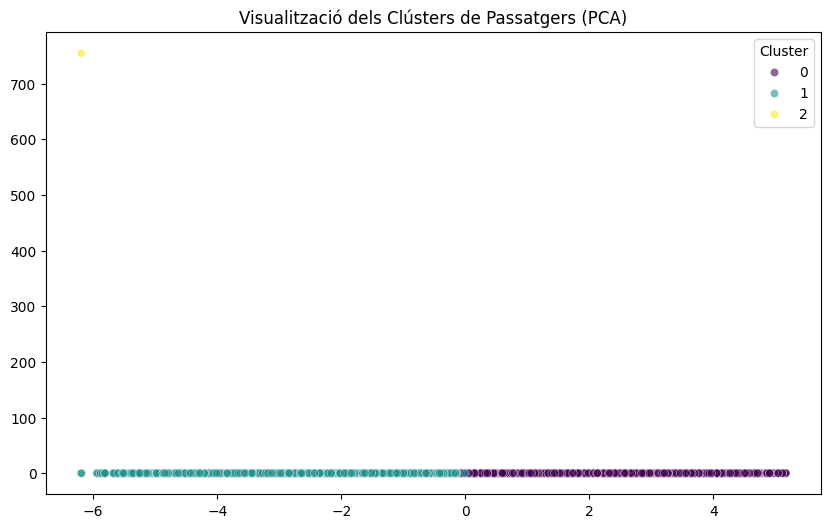

Perfil dels Clústers (Mitjanes):


,Flight Distance,Class,satisfaction
Cluster,,,
0,1478.604311,1.466507,0.733334
1,908.736533,0.604033,0.142225
2,3.000000,1.000000,2.000000


In [29]:
# --- 4. EDA I CLUSTERING (NOMÉS SOBRE TRAIN) ---
# Normalitzem dades per al clustering
scaler_cluster = StandardScaler()
X_cluster = df_train.drop(['satisfaction'], axis=1)

# CORRECCIÓN: Rellenar cualquier NaN restante en X_cluster antes de escalar
# Esto es crucial ya que K-Means no acepta NaNs.
for col in X_cluster.columns:
    if X_cluster[col].isnull().any():
        median_val = X_cluster[col].median()
        if pd.isna(median_val): # Si la mediana es NaN (ej. la columna entera es NaN)
            X_cluster[col] = X_cluster[col].fillna(0)
        else:
            X_cluster[col] = X_cluster[col].fillna(median_val)

X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# K-Means (Exemple amb 3 clústers)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_train['Cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Visualització dels perfils (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_train['Cluster'], palette='viridis', alpha=0.6)
plt.title("Visualització dels Clústers de Passatgers (PCA)")
plt.show()

# Anàlisi dels perfils (Important per al Markdown de la pràctica)
print("Perfil dels Clústers (Mitjanes):")
display(df_train.groupby('Cluster')[['Flight Distance', 'Class', 'satisfaction']].mean())

🚀 Començant entrenament...
✅ Perceptron: Acc=0.8448 | Temps: 3.5s
✅ Logistic Regression: Acc=0.8702 | Temps: 1.0s
✅ Decision Tree: Acc=0.9308 | Temps: 1.1s
✅ Random Forest: Acc=0.9518 | Temps: 27.1s
✅ SVM: Acc=0.9438 | Temps: 48.2s


,Model,Test Accuracy,Best Params
3,Random Forest,0.951840,"{'max_depth': 20, 'n_estimators': 200}"
4,SVM,0.943756,"{'C': 10, 'kernel': 'rbf'}"
2,Decision Tree,0.930821,"{'max_depth': 10, 'min_samples_leaf': 1}"
1,Logistic Regression,0.870188,"{'C': 1, 'solver': 'newton-cg'}"
0,Perceptron,0.844780,"{'alpha': 0.001, 'penalty': 'elasticnet'}"



Matriu de Confusió del guanyador: Random Forest


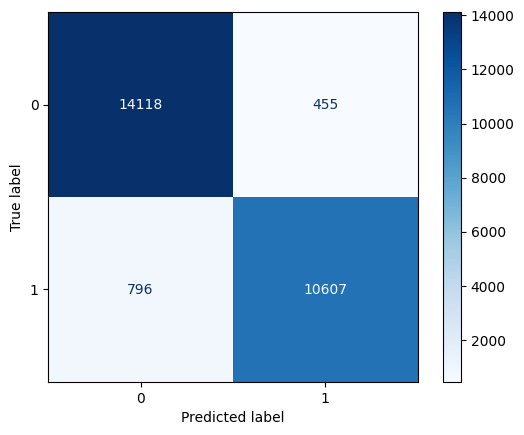

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import time

# --- 5. PREPARACIÓ PER A L'ENTRENAMENT ---
# Definim X_train, y_train, X_test, y_test DIRECTAMENT dels dataframes
# Eliminem 'Cluster' perquè no existeix a Test (i no volem dependre'n per predir)
X_train = df_train.drop(['satisfaction', 'Cluster'], axis=1)
y_train = df_train['satisfaction']

X_test = df_test.drop(['satisfaction'], axis=1, errors='ignore') # 'Cluster' no hi és al test
y_test = df_test['satisfaction']

# Escalat (Molt important fer fit només a Train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Diccionari de models ajustat als requisits (3 valors per paràmetre)
models_params = {
    'Perceptron': {
        'model': Perceptron(random_state=42),
        'params': {
            'penalty': ['l2', 'l1', 'elasticnet'],     # 3 valors
            'alpha': [0.0001, 0.001, 0.01]             # 3 valors
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=2000),
        'params': {
            'C': [0.1, 1, 10],                         # 3 valors
            'solver': ['liblinear', 'lbfgs', 'newton-cg'] # 3 valors
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [5, 10, 20],                  # 3 valors
            'min_samples_leaf': [1, 5, 10]             # 3 valors
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],            # 3 valors
            'max_depth': [10, 20, 30]                  # 3 valors
        }
    },
    # SVM és lent, el deixem al final. Si triga massa, redueix el dataset de tuning
    'SVM': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],                         # 3 valors
            'kernel': ['rbf', 'poly', 'sigmoid']       # 3 valors
        }
    }
}

# --- 6. BUCLE D'ENTRENAMENT ---
results = []
best_classifiers = {}

print("🚀 Començant entrenament...")

for name, mp in models_params.items():
    start = time.time()

    # Utilitzem un subset per al GridSearch (Tuning) per velocitat
    # Però avaluem finalment sobre TOT el test set.
    if len(X_train_scaled) > 10000:
        X_tune = X_train_scaled[:10000]
        y_tune = y_train[:10000]
    else:
        X_tune = X_train_scaled
        y_tune = y_train

    # GridSearch
    grid = GridSearchCV(mp['model'], mp['params'], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_tune, y_tune)

    best_model = grid.best_estimator_
    best_classifiers[name] = best_model

    # Predicció final sobre el TEST REAL (l'arxiu test.csv)
    y_pred = best_model.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Test Accuracy': test_acc,
        'Best Params': grid.best_params_
    })

    print(f"✅ {name}: Acc={test_acc:.4f} | Temps: {time.time()-start:.1f}s")

# --- 7. VISUALITZACIÓ DE RESULTATS ---
results_df = pd.DataFrame(results).sort_values(by='Test Accuracy', ascending=False)
display(results_df)

# Matriu de confusió del millor model
best_name = results_df.iloc[0]['Model']
print(f"\nMatriu de Confusió del guanyador: {best_name}")
ConfusionMatrixDisplay.from_estimator(best_classifiers[best_name], X_test_scaled, y_test, cmap='Blues')
plt.show()